# Miniproject 2: Chatbot

## Introduction

### Description

Developing a model employing ANN on real-world data requires going through several major steps, each of which with 
important design choices that directly impact the final results. 
In this project, we guide you through these choices starting from a large database of 
[conversations](http://parl.ai/downloads/personachat/personachat.tgz) to a functional chatbot. 

### Prerequisites

- You should have a running installation of [tensorflow](https://www.tensorflow.org/install/) and [keras](https://keras.io/).
- You should know the concepts "recurrent neural networks", "LSTM", "training and validation data", "overfitting" and "early stopping".

### What you will learn

- You will be guided through a data processing procedure and understand the importance of design choices in ANN modeling
- You will learn how to define recurrent neural networks in keras and fit them to data.
- You will be guided through a prototyping procedure for the application of deep learning to a specific domain.
- You will get in contact with concepts discussed in the lecture, like "overfitting", "LSTM network", and "Generative model".
- You will learn to be more patient :) Some fits may take your computer quite a bit of time; run them over night and make sure you save (and load) your data and models.

### Evaluation criteria

The evaluation is (mostly) based on the figures you submit and your answer sentences. 
We will only do random tests of your code and not re-run the full notebook. 
Please ensure that your notebook is fully executed before handing it in. 

### Submission 

You should submit your notebook through the Moodle page submission tool. You should work in teams of two people and each member should submit the same notebook to Moodle.



## Functions and imports

For your convenience we import some libraries and provide some functions below. Fill in your names, sciper numbers and run the following cell.

In [1]:
names = {'student_1': "Zeki Doruk Erden",
        'student_2': "Ayberk Ozkirli"}

sciper = {'student_1': 295453, 
          'student_2': 297914}

seed = sciper['student_1']+sciper['student_2']

%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import os, sys
import copy
import random

plt.rcParams['font.size'] = 28
plt.style.use('ggplot')
plt.rcParams["axes.grid"] = False
c = plt.rcParams['axes.prop_cycle'].by_key()['color']

import keras
from keras.models import Model, load_model
from keras.layers import Input, Masking, TimeDistributed, Dense, Concatenate, Dropout, LSTM, GRU, SimpleRNN, Bidirectional, Embedding, BatchNormalization
from keras.optimizers import Adam
from keras.utils import np_utils
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import ModelCheckpoint, EarlyStopping


def getRawDataFromFile(datapath="data/personachat/", file="train_both_revised.txt"):
    
    f = open(datapath+file)

    conversations = []
    current_conversation = []
    
    for l, line in enumerate(f):
        #print(l, line)
        if "persona:" in line:
            if len(current_conversation) > 1:
                conversations.append(current_conversation)
            current_conversation = [] 
            continue

        #remove numberings
        processed_line = line.split(' ')
        processed_line = " ".join(processed_line[1:])
        line = processed_line
        #print(line)

        conv = line.split('\t')    
        q = conv[0]
        a = conv[1]
        current_conversation.append(q)
        current_conversation.append(a)
    
    return conversations 

Using TensorFlow backend.


## Data visualization and preprocessing

Here we will process and visualize the data.


### Parse raw data 

Download the dataset on http://parl.ai/downloads/personachat/personachat.tgz. Unpack it and add it to your project folder. Read and run the getRawDataFromFile function (if needed, modify the default path). It extracts the conversations.

**Output** Display two randomly selected conversations. [1 pt]

In [2]:
conversations = getRawDataFromFile(datapath="personachat/", file="train_both_revised.txt")
c1 = 0
c2 = 0
while(c1==c2):
    c1 = random.randint(0,len(conversations))
    c2 = random.randint(0,len(conversations))
print('Conversation 1: ', conversations[c1])
print('Conversation 2: ', conversations[c2])

Conversation 1:  ['hi ! tell me a bit about yourself !', 'hi ! well the major thing you will notice about me in person is my bright red hair .', 'oh really ! i ai not seen a lot of redheads around here . you irish ?', 'sure am ! how about yourself ?', 'well the ocean is practically my home . always out sailin', 'i am more of singing in the shower type of person , or swimming in a pool .', 'ah come on , you have not lived until you have swam with the wildlife of the ocean .', 'no thanks ! i will stick my toes in . that is it . what else do you do for fun ?', 'i like to go fishin and read while i am waiting . love me som jane austin . you ?', 'i like mystery books . i am a big fan of the da vinci code series .', 'nah those are too intense for me , i am more of a chill guy', 'no plot to take over the world books , huh ?', 'nah , not for me . what kinda food you like ?', 'i am a stickler for pasta . how about yourself ?', 'fish ! catfish is my favorite', 'i have never had catfish . i do en

In [3]:
# Hold the original conversations file for further reference
conversations_org = getRawDataFromFile(datapath="personachat/", file="train_both_revised.txt")

### Extract word tokens

Let's start looking at our data. 

**Code** Compute the set of unique words (dictionary) in all sentences along with the number of occurences of each of these words. HINT: each word is separated by a space character, use the python string.split(' ') function to separate words. Consider punctuations as 'words'. [1 pt]

**Figure** In a bar plot, show the first 75 most frequent words (x-axis) and their number of occurences (y-axis). [1 pt]

**Figure** In another bar plot, show the 75 least frequent words (x-axis) and their number of occurences (y-axis). [1 pt] 

**Figure** In a log-log scale, plot the sorted word index (x-axis) vs their respective count (y-axis). [1 pt]

**Question** Relate the sorted word count distribution with Zipf's law.
Argue using the log-log plot. [1 pt]

**Answer:** Zipf's Law states that  given a large sample of words used, the frequency of any word is inversely proportional to its rank in the frequency table, i.e. word number n has a frequency proportional to 1/n. In the log-log scale, this means linearly decreasing relation of occurence with log(n). We verify this empirical law on our Sorted Word Index vs. Word Count log-log plot: Logarithm of word index and logarithm of instances seen are near-linearly related. (See Figure "Sorted Word Index vs. Count" below.)

**Question** How many words appear only once in the entire dataset? [1 pt]

**Answer:** There are 7080 words that appear only once in the entire dataset.



In [4]:
word_counter = {};
for conversation in conversations:
    for sentence in conversation:
        words=sentence.split();
        for word in words:
            if word in word_counter:
                word_counter[word]+=1;
            else:
                if(not((word==',')or(word=='.')or(word=='!')or(word==':')or(word==';')or(word=='?'))): # Don't count punctuations
                    word_counter[word]=1;

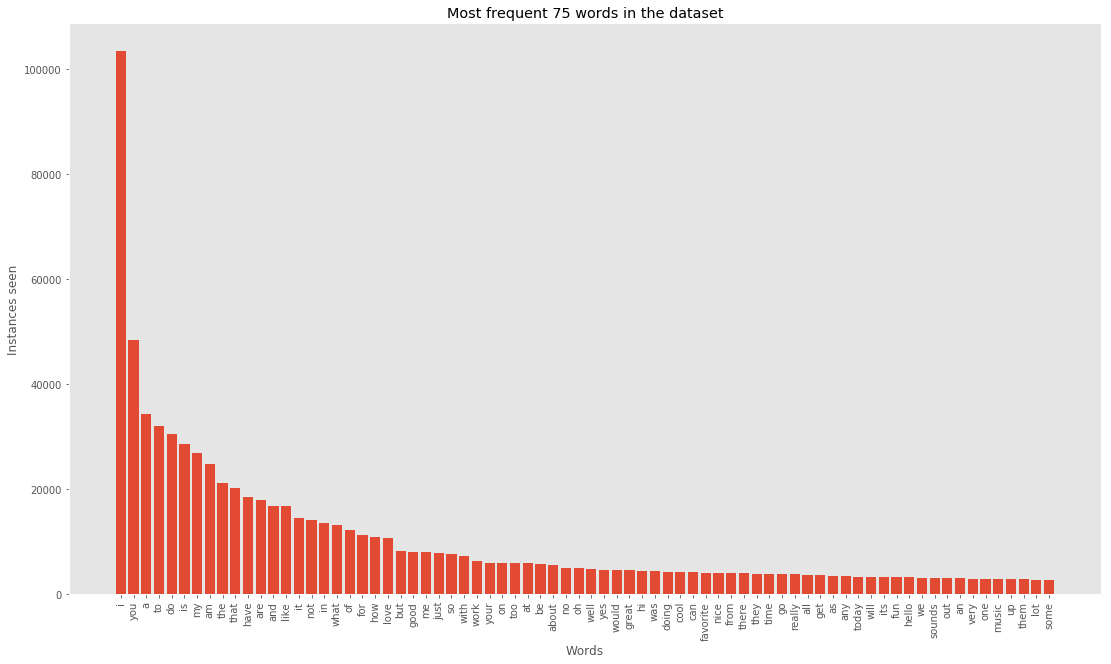

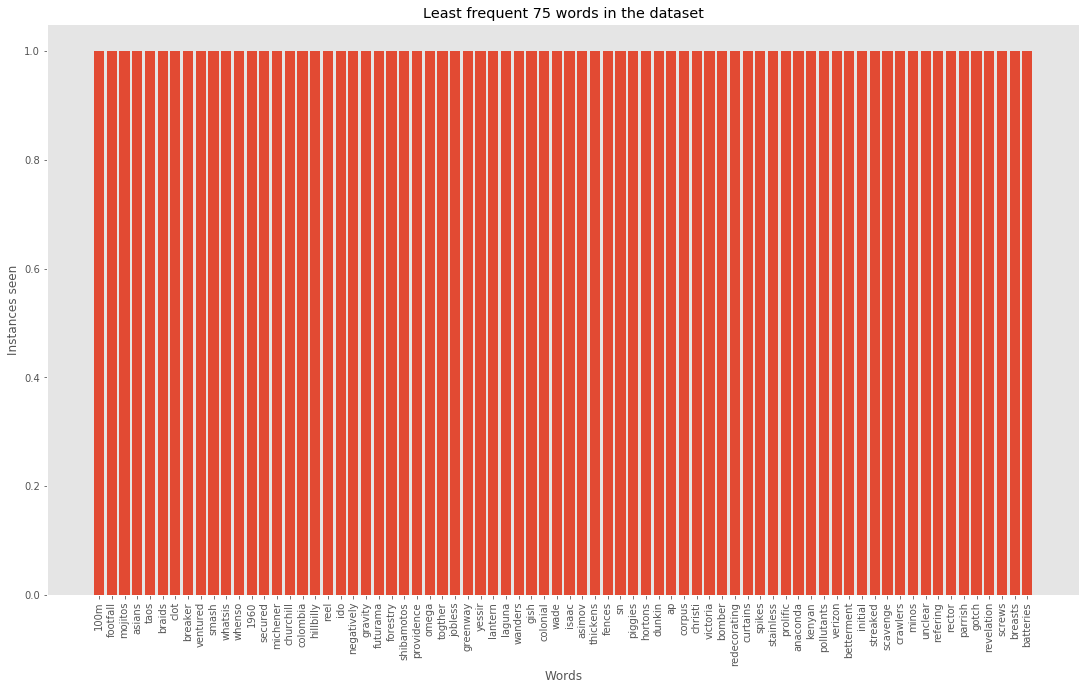

In [5]:
# Most frequent
word_counter_sorted_des = sorted(word_counter.items(), key=lambda x: x[1], reverse=True) # Sort word counter in descending order
word_counter_75 = word_counter_sorted_des[0:74]
word_list = []
word_inst = []
for word_element in word_counter_75:
    word_list.append(word_element[0])
    word_inst.append(word_element[1])
x = np.arange(len(word_counter_75)) # For plotting
fig = plt.figure();
fig.set_size_inches(18.5, 10.5)
plt.bar(x, word_inst)
plt.xticks(x,word_list,rotation=90)
plt.xlabel('Words')
plt.ylabel('Instances seen')
plt.title('Most frequent 75 words in the dataset')
plt.show()

# Least frequent
word_counter_sorted_asc = sorted(word_counter.items(), key=lambda x: x[1]) # Sort word counter in ascending order
word_counter_75 = word_counter_sorted_asc[0:74]
word_list = []
word_inst = []
for word_element in word_counter_75:
    word_list.append(word_element[0])
    word_inst.append(word_element[1])
x = np.arange(len(word_counter_75)) # For plotting
fig2 = plt.figure();
fig2.set_size_inches(18.5, 10.5)
plt.bar(x, word_inst)
plt.xticks(x,word_list,rotation=90)
plt.xlabel('Words')
plt.ylabel('Instances seen')
plt.title('Least frequent 75 words in the dataset')
plt.show()

Text(0.5, 1.0, 'Sorted Word Index vs. Count')

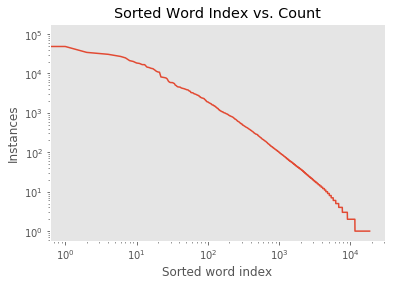

In [6]:
word_inst = []
for word_element in word_counter_sorted_des:
    word_inst.append(word_element[1])
x = np.arange(len(word_inst))
plt.loglog(x,word_inst)
plt.xlabel('Sorted word index')
plt.ylabel('Instances')
plt.title('Sorted Word Index vs. Count')

In [7]:
n_once = 0
for count in word_inst:
    if(count == 1):
        n_once += 1
print('There are ' + str(n_once) + ' words that appear only once in the entire dataset.')

There are 7080 words that appear only once in the entire dataset.


### Filtering

We suggest to filter your data by removing sentences containing rare words. 


**Code** To achieve that, you should create a new dataset where sentences containing rare words (words that occur less than N times in the dataset) are removed. Keep at least 50'000 sentences (depending on your computing power, you can keep more). 
HINT: Start by updating the dictionary accordingly and then remove any sentence that contains at least a single word that is not in the dictionary of words. [2 pts]

**Question**: How much did you reduce the number of unique words with your rare event suppression procedure? [1 pt]
    
**Answer**: Number of unique words reduced from 7080 to 0.

**Question**: How many sentences are in your filtered and original dataset? [1 pt]

**Answer**: Original: 131424 ; Filtered: 51008.

**Question**: What is the impact on learning and generalization of removing sentences with rare words from your dataset? [2 pt]

**Answer**: We can think of the sentences with rare words as "statistical outliers" in terms of statistics. Therefore, since the model won't try to learn these outliers, we expect learning and generalization performance to increase after this removal procedure.

In [8]:
# Calculate the number of sentences in the dataset
n_sentence = 0
for conversation in conversations:
    for sentence in conversation:
        n_sentence +=1
print('Before filtering: '+ str(n_sentence) + ' sentences.')


Before filtering: 131424 sentences.


In [9]:
N = 100 # Limit for occurence to discard sentence. Determined experimentally.
# Update word dictionary to delete rare words
rare_words = []
for word in word_counter:
    if(word_counter[word]<N):
        rare_words.append(word)
                
word_counter_filtered = word_counter.copy()
for word in rare_words:
        del word_counter_filtered[word]
        
# Check sentences for words that are not in dictionary
toremove = []
conversations_filtered = conversations.copy()
for conversation in conversations_filtered:
    for sentence in conversation:
        words=sentence.split();
        for word in words:
            if(not(word in word_counter_filtered) and (not((word==',')or(word=='.')or(word=='!')or(word==':')or(word==';')or(word=='?')))):
                toremove.append(sentence)
                break
    
remove_index = 1
for conversation in conversations_filtered:
    for sentence in toremove:
        if(sentence in conversation):
#           print('Removing ' + str(remove_index) + ' of ' + str(len(toremove)))
            conversation.remove(sentence)
            remove_index += 1
                

n_sentence = 0
for conversation in conversations_filtered:
    for sentence in conversation:
        n_sentence +=1
print('After filtering: '+ str(n_sentence) + ' sentences.')                


    

After filtering: 51008 sentences.


In [10]:
word_inst = []
for word_element in word_counter_filtered:
    word_inst.append(word_counter_filtered[word_element])
n_once = 0
for count in word_inst:
    if(count == 1):
        n_once += 1
print('There are ' + str(n_once) + ' words that appear only once in the entire dataset after filtering.')

There are 0 words that appear only once in the entire dataset after filtering.


### Tokenization and padding

Now you will transform our filtered data into a format that is understandable by an ANN. To achieve that, you should transform words to integers, where single integers in the range [1,size of the dictionary] are mapped to single words in your dictionary. This process is commonly named 'tokenization'. In addition, we will keep the value 0 to a specific artificial word 'PADD' that will be used to account for the variable length of sentences and add to each sentence a 'START' and an 'END' word. 

**Code** Start by adding the three artificial words to your dictionary (list of possible tokens) and then translate every sentences to a list of integers. 
HINT: use the Python List index() method. [2 pts]

**Figure** Use the violinplot to show the density of tokenized sentences length. [1pt]

**Code** From this figure, select a maximum number (=maxlen) of tokens for which most of the sentences have less. Padd (and eventually truncate) all sentences with the 'PADD' token (value 0 in the integer representation) until all tokenized sentences have the same length (maxlen).
HINT: use the pad_sequences function from keras.preprocessing.sequence [2 pts]

**Code** Check that you can recover the original sentence. Randomly select two sentences from your integer and padded representation and translate them back using your dictionary. [1 pt]

In [11]:
word_dict = word_counter_filtered
# Add artificial words
word_dict['START'] = 0
word_dict['END'] = 0
word_dict['PADD'] = 0 # Note that value reserved for PADD is 0
# Transform to list
word_list = []
for key in word_dict.keys():
    word_list.append(key)

In [12]:
tokenized = conversations.copy()
for conv_ind in range(len(tokenized)):
    conversation = tokenized[conv_ind]
    for sent_ind in range(len(conversation)):
        sentence = conversation[sent_ind]
        words = sentence.split()
        new_sent = [word_list.index('START')]
        for word in words:
            if(not((word==',')or(word=='.')or(word=='!')or(word==':')or(word==';')or(word=='?'))):
                token = word_list.index(word)
                new_sent.append(token)
        new_sent.append(word_list.index('END'))
        conversation[sent_ind] = new_sent

Text(0.5, 1.0, 'Violin Plot of Tokenized Sentence Lenght')

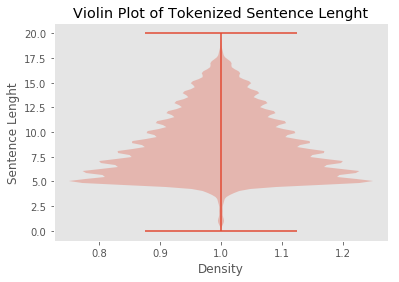

In [13]:
# Get sentence lenght distribution
sentence_lenghts = []
for conversation in tokenized:
    for sentence in conversation:
        sentence_lenghts.append(len(sentence)-2) # Subtract START and END words

# Violin plot
plt.violinplot(sentence_lenghts)
plt.xlabel('Density')
plt.ylabel('Sentence Lenght')
plt.title('Violin Plot of Tokenized Sentence Lenght')

In [14]:
# Order to be last of list of integers and padd
tokens_raw = []
for conversation in tokenized:
    for sentence in conversation:
        tokens_raw.append(sentence)
        



maxlenght = 15
tokens = keras.preprocessing.sequence.pad_sequences(tokens_raw, maxlen=maxlenght, padding='pre', truncating='pre', value=0)


In [15]:
# Recovery
s1 = random.randint(0,len(tokens)-1)
s2 = random.randint(0,len(tokens)-1)
s1_token = tokens[s1]
s2_token = tokens[s2]

print('RECOVERED SENTENCES:')

s1_rec = ""
for token in s1_token:
    if ((token==0)or(token==word_list.index('START'))or(token==word_list.index('END'))):
        word_rec = [] # PADD, START or END
    else:
        word_rec = word_list[token]
        s1_rec += (word_rec + " ")
print('First sentence: ', s1_rec)

s2_rec = ""
for token in s2_token:
    if ((token==0)or(token==word_list.index('START'))or(token==word_list.index('END'))):
        word_rec = [] # PADD, START or END
    else:
        word_rec = word_list[token]
        s2_rec += (word_rec + " ")
print('Second sentence: ', s2_rec)

RECOVERED SENTENCES:
First sentence:  hey what is going on with you tonight 
Second sentence:  good i am just relaxing at home you 


In [16]:
# Convention for naming
filtered_sentences = word_counter_filtered
dictionary = word_dict

### Saving

Now is a good time to save your data (end of processing). An example code using the pickle library is shown below.


In [82]:
import pickle

#save
with open("data.pkl", "wb") as file:
    pickle.dump([filtered_sentences, dictionary, tokens], file)
    
#load
#with open("data.pkl", "rb") as file:
#    [filtered_sentences, dictionary, tokens] = pickle.load(file)

## Building and training generative models of language

### RNN vs LSTM vs GRU 

Build, train and compare generative models of language based on RNNs with different recurrent units (SimpleRNN, GRU and LSTM). 

The target of the network will be to approximate the word transition probabilities Pr(word[n+1]|H[n]) with H[n]=f(word[:n]) being the hidden state of the network.  

**code** You should complete the proposed model (using the Keras API rather than the Sequential model for more flexibility). Be sure to understand each line. The embedding layer allows to transform an integer to a dense vector. That would be our input to the recurrent network - each sentence is mapped to a sequence of vectors, each representing a single word. You can then design your own readout(s) and output layers. By default, use the proposed meta parameters. You can adapt them if you have more or less computing power (32 epochs should take around 30 minutes). [2 pts]

**Question** How will your networks deal with the artificial word 'PADD' that you added at the end of each sentences  [2 pts]

**Answer**

**code** Then train three different networks with the same architecture but using different recurrent units (simpleRNN, GRU and LSTM). Save the learning history (training/validation loss and accuracy for each epoch) as well as the models. [1 pt]

**Question** How can you use this network to approximate the word transition probabilities? What will be the inputs and targets of the network at each batch? Give the input/output tensor dimensions. [2 pts]

**Answer**

**Figure** Show the learning curves (training and validation loss) for the different recurrent units. [1 pt]

**Figure** Show the learning curves (training and validation accuracy) for the different recurrent units. [1 pt]

**Question:** Which recurrent unit yields the best validation accuracy? Which is the fastest learner? [1 pt]

**Answer**: 

**Question:** Do you observe an overfitting effect? Where and for which case? Give a possible explanation. [1 pt] 

**Answer**: 

**Question:** Suggest one option modifying your dataset to decrease overfitting. [1 pt]

**Answer**: 

**Question:** Suggest one possible option modifying your network to decrease overfitting. [1 pt]

**Answer**: 

**Question:** Suggest one possible option modifying the training modalities to counter overfitting. [1 pt]   

**Answer**: 

In [17]:
#Meta-parameters
embedding_size = 128
hidden_size = 64
dropout = 0.
recurrent_dropout = 0.

batch_size = 64
epochs = 32
validation_split = 0.2

dataset_cut = -1

In [18]:
I = {}
E = {}
H = {}
R = {}
Y = {}
models = {}
logs = {}

In [19]:
#Model suggestion

I['RNN'] = Input(shape=(maxlenght-1,), name="input")
E['RNN'] = Embedding(len(tokens), embedding_size, mask_zero=True, name="embedding")(I['RNN'])

#your network here
H['RNN'] = keras.layers.SimpleRNN(hidden_size, activation='tanh', dropout=dropout, recurrent_dropout=recurrent_dropout)(E['RNN']) #... Recurrent layer(s)

#R['RNN'] = #... Readout
Y['RNN'] = keras.layers.Dense(14)(H['RNN']) #... Output

models['RNN'] = Model(inputs = [I['RNN']], outputs = [Y['RNN']])
models['RNN'].compile(
    loss='categorical_crossentropy', 
    optimizer=Adam(),
    metrics=['acc'])
models['RNN'].summary()

# Added
X = tokens
T = tokens
# End Added

# Reshape from [samples, time steps] to [samples, time steps, features]
# trainX = np.reshape(X, (X.shape[0], X.shape[1], 1))
# trainY = T


print(X[:,:-1].shape, T[:,1:].shape)
logs['RNN'] = models['RNN'].fit(X[:dataset_cut,:-1], T[:dataset_cut,1:], 
                                    epochs=epochs, 
                                    validation_split=validation_split, 
                                    batch_size=batch_size).history

#save
#with open("RNNmodel_"+str(embedding_size)+'_'+str(hidden_size)+"_log.pkl", "wb") as file:
#    pickle.dump(logs['RNN'], file)
#models['RNN'].save("RNNmodel_"+str(embedding_size)+'_'+str(hidden_size))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 14)                0         
_________________________________________________________________
embedding (Embedding)        (None, 14, 128)           6529024   
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 64)                12352     
_________________________________________________________________
dense_1 (Dense)              (None, 14)                910       
Total params: 6,542,286
Trainable params: 6,542,286
Non-trainable params: 0
_________________________________________________________________
(51008, 14) (51008, 14)
Train on 40805 samples, validate on 10202 samples
Epoch 1/32
40805/40805 [==============================] - 215s 5ms/step - loss: 25695.9497 - acc: 0.2170 - val_loss: 26902.2439 - val_acc: 0.0737
Epoch 2/32
40805/40805 [====================

KeyboardInterrupt: 

In [102]:
tokens

array([[   0, 1007,    3, ...,   24,   25, 1008],
       [1007,   34,   20, ...,   22,   44, 1008],
       [   0,    0,    0, ...,    9,   49, 1008],
       ...,
       [   0,    0,    0, ...,    3,    4, 1008],
       [   5,    6,    4, ...,   92,  502, 1008],
       [   5,  163,   26, ...,    3,  166, 1008]])

In [ ]:
#load
with open("RNNmodel_"+str(embedding_size)+'_'+str(hidden_size)+"_log.pkl", "rb") as file:
    RNNmodel_log = pickle.load(file)
RNNmodel = load_model("RNNmodel_"+str(embedding_size)+'_'+str(hidden_size))

In [96]:
# Sketch
I['RNN'] = Input(shape=(maxlenght-1,), name="input")
E['RNN'] = Embedding(len(tokens), embedding_size, mask_zero=True, name="embedding")(I['RNN'])

#your network here
H['RNN'] = keras.layers.SimpleRNN(hidden_size, activation='tanh', dropout=dropout, recurrent_dropout=recurrent_dropout)(E['RNN']) #... Recurrent layer(s)
Y['RNN'] = keras.layers.Dense(1)(H['RNN']) #... Output

model = Model(inputs = [I['RNN']], outputs = [Y['RNN']])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 14)                0         
_________________________________________________________________
embedding (Embedding)        (None, 14, 128)           6529024   
_________________________________________________________________
simple_rnn_5 (SimpleRNN)     (None, 64)                12352     
_________________________________________________________________
dense_22 (Dense)             (None, 1)                 65        
Total params: 6,541,441
Trainable params: 6,541,441
Non-trainable params: 0
_________________________________________________________________


In [95]:
# Sketch
I['RNN'] = Input(shape=(maxlenght-1,), name="input")
E['RNN'] = Embedding(len(tokens), embedding_size, mask_zero=True, name="embedding", input_shape=(maxlenght-1,))

#your network here
H['RNN'] = keras.layers.SimpleRNN(hidden_size, activation='tanh', dropout=dropout, recurrent_dropout=recurrent_dropout) #... Recurrent layer(s)
Y['RNN'] = keras.layers.Dense(1) #... Output

model = keras.models.Sequential()
model.add(E['RNN'])
model.add(H['RNN'])
model.add(Y['RNN'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 14, 128)           6529024   
_________________________________________________________________
simple_rnn_4 (SimpleRNN)     (None, 64)                12352     
_________________________________________________________________
dense_21 (Dense)             (None, 1)                 65        
Total params: 6,541,441
Trainable params: 6,541,441
Non-trainable params: 0
_________________________________________________________________


In [91]:
# Sketch
inputs = Input(shape=(784,))

# a layer instance is callable on a tensor, and returns a tensor
x = Dense(64, activation='relu')(inputs)
model = Model(inputs=inputs, outputs=x)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 784)               0         
_________________________________________________________________
dense_18 (Dense)             (None, 64)                50240     
Total params: 50,240
Trainable params: 50,240
Non-trainable params: 0
_________________________________________________________________


### Optimal network size

Compare the learning curves for three networks with 64 (previous exercise), 128 and 256 GRUs (single layer) and one with two hidden layers of 64 GRUs. 

**Code** Build and train the networks. Apply EarlyStopping (monitor='val_acc', min_delta=0.001, patience=2). Use transfer learning, do not train from scratch your embedding layer, rather re-use the embedding layer from your best performing network in the last exercise. [4 pts]

**Figure** Show the learning curves (training and validation loss) for the four models. [1 pt]

**Figure** Show the learning curves (training and validation accuracy) for the four models. [1 pt]

**Question** List and briefly explain the differences in the learning curves for the different models? [2 pts]

**Answer**

**Question** What effect had EarlyStopping? Give one advantage and one drawback. [2 pts]

**Answer**

**Question** What is your best model? Why? [1 pt]

**Answer**



### Generate sentences

Now you will generate new sentences from your best performing model.

**Code** To achieve that, use the provided sample function below to generate new sentences from your model. You should start by constructing a sentence that starts with the 'START' artificial word and all other words being the 'PADD' artificial word. Then sample the first word from the corresponding probabilities given by your model. Add this word to the sentence and continue like this until you sample the 'END' artificial word or the maximum sentence length. [2 pts]

**Code** Generate 10 sentences for different sampling temperature in [0., 0.25, 0.5, 0.75, 1., 1.5., 2.]. [1 pt]

**7 Figures** For each temperature, use matplotlib imshow to plot the probablities of every word in one generated sentence (and only these words) at each time step. y-axis should be the words that are present in the sentence. x-axis the timesteps and the imshow value the probabilities given by the model for all words in the sentence at each timestep. Use the a colormap where 0 is white, e.g. cmap='Greys'. [2 pts]

**Code** Finally, seed your model with two different beginnings of max 4 words and let it generate 10 possible continuations (use sampling temperature of 1.). [2 pts]

**Question** What is the effect of sampling temperature on the generated sentences? [1 pt]

**Answer**

**Question** In terms of sampling a probability distribution, what does a sampling temperature of 0 corresponds to? [1 pt] 

**Answer**

**Question** In terms of sampling a probability distribution, what does a sampling temperature of 1. corresponds to? [1 pt] 

**Answer**

**Question** In terms of sampling a probability distribution, what does a very high sampling temperature corresponds to? [1 pt]

**Answer**

**Question** Based on the plotted word probabilities, explain how a sentence is generated. [2 pts]

**Answer**

**Question** Do you observe timesteps with more than one word with non-zero probability? How do these probable words relate in terms of language? [1 pt]

**Answer**

In [ ]:
def sample(preds, temperature=1.):
    # helper function to sample an index from a probability array
    if temperature == 0.:
        return np.argmax(preds)
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)


###  Word embedding visualization

Here, you are asked to visualize the embedding layer. 

**Code** To do that, project in 2D the embedding vectors for different words. Use t-SNE, a projection that conserve the neighborhood relationships between vectors. HINT: Build a Keras model that takes as input a list of words and outputs a list of vector embeddings as learned by your best performing model. Use t-SNE dimensionality reduction (from sklearn.manifold import TSNE). [2 pts]

**Figure** Plot the projection of the first 200 most frequent words in a 2D plot. On the plot, write the words. [2 pt] 

**Question** Do you observe clusters of words with similar meaning or role in language? Report three of them here. [1 pt]

**Answer**

**Question** Why is having similar vector representation for similar words a good approach for such models? Explain using the example clusters from before and argue in terms of prediction accuracy and/or generalization. [2 pts]

**Answer**

## Chatbot

Finally, you will construct a model with which you can chat. The network will take as input a sentence and output a response.

**Code** For that, you should go back to your original data and construct a new dataset containing pairs of sentences, where each pair is a sentence and its answer. Be careful to not include any pair of sentences that contains words not present in your filtered dictionary. [2 pts]

**Code** You should then tokenize, padd, truncate each sentence. Only the answers need the 'START' and 'END' artificial words. [1 pt]

We provide you with a possible model, you are welcome to change it. This model uses an LSTM layer to encode the first sentence (the context). The final state of this LSTM layer is transfered to initialize the state of a decoder LSTM layer from which the answer sentence will be generated. 

**Code** Train your chatbot model on your dataset. [1 pt]

**Code** Adapt your sentence generation code from before so that you can generate an answer given a context sentence from your model. [2 pts] 

**Code** After training, randomly select 10 context-answers pairs from your data and show both the real answer (the one from the data) and the generated one for two different sampling temperatures (e.g. 0.5 and 1.0). [2 pts]

**Question** How similar are the generated answers and the real ones? Does your model provide probable answers (given the dataset)? Report here one good and one bad example. [2 pts]

**Answer**

**Question** Which sampling temperature gives better answers? why? [2 pts]

**Answer**

**Question** Would it be good if your model was able to reproduce exactly each real answer? Why? [1 pt]

**Answer**

**Code** Entertain yourself with your model. Write some code to chat with your bot, let it discuss with itself, ... be creative! [2 **bonus** pts]




In [ ]:
context = Input(shape=(maxlen-2,), name="input_context")
shared_embedding = E['GRU']
context_embedding = shared_embedding(context)

encoder_y, encoder_h, encoder_c = LSTM(hidden_size, 
            return_sequences=False,
            return_state=True,
            stateful=False,
            dropout=dropout,
            recurrent_dropout=recurrent_dropout,
            go_backwards=True,
            name="encoder")(context_embedding)

answer = Input(shape=(maxlen-1,), name="input_answer")
answer_embedding = shared_embedding(answer)

decoder_input = answer_embedding
decoder = LSTM(hidden_size, 
            return_sequences=True,
            stateful=False,
            dropout=dropout,
            recurrent_dropout=recurrent_dropout,
            name="decoder")(answer_embedding, initial_state=[encoder_h, encoder_c])
# decoder2 = LSTM(hidden_size, 
#             return_sequences=True,
#             stateful=False,
#             dropout=dropout,
#             recurrent_dropout=recurrent_dropout,
#             name="decoder2")(decoder)

R = TimeDistributed(Dense(embedding_size, activation='relu'), name='readout')(decoder)
Y = TimeDistributed(Dense(len(tokens), activation='softmax'), name='output')(R)

Chatbot = Model(inputs = [context, answer], outputs = [Y])
Chatbot.compile(
    loss='categorical_crossentropy', 
    optimizer=Adam(),
    metrics=['acc'])
Chatbot.summary()
